![example](images/director_shot.jpeg)

# Microsoft Movie Recommendations

**Author:** Lia Elwonger
***

## Overview

Microsoft is perhaps best know as a software company, but has many media holding, perhaps most notably in video games via their Xbox consoles and games. How might this company leverage its capital and brand to enter into the film industry?

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [13]:
# Here you run your code to explore the data
path = 'data/zippedData/bom.movie_gross.csv.gz'
bom_df = pd.read_csv(path)

In [14]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [15]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [16]:
# missing a few studios and over a thousand foreign gross datapoints

In [17]:
path = 'data/zippedData/imdb.title.ratings.csv.gz'
ratings_df = pd.read_csv(path)

In [18]:
ratings_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [19]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [20]:
# Figure out what tconst represents

In [22]:
path = 'data/zippedData/imdb.name.basics.csv.gz'
names_df = pd.read_csv(path)
names_df.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [23]:
# Clearly the a list of people working on project
# Consider making recs on who to hire?

In [24]:
path = 'data/zippedData/imdb.title.basics.csv.gz'
titles_df = pd.read_csv(path)
titles_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [25]:
# tconst is a title key

In [26]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [27]:
# a few missing original titles, which likely doesn't matter
# a few (maybe 5%) missing genres which we will probably just drop

In [28]:
path = 'data/zippedData/imdb.title.principals.csv.gz'
principles_df = pd.read_csv(path)
principles_df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [29]:
path = 'data/zippedData/imdb.title.akas.csv.gz'
akas_df = pd.read_csv(path)
akas_df.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


In [30]:
# contains titles for non english markets

In [31]:
path = 'data/zippedData/tn.movie_budgets.csv.gz'
budgets_df = pd.read_csv(path)
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [32]:
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [33]:
budgets_df.set_index('movie', inplace=True)
budgets_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009","$425,000,000","$760,507,625","$2,776,345,279"
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011","$410,600,000","$241,063,875","$1,045,663,875"
Dark Phoenix,3,"Jun 7, 2019","$350,000,000","$42,762,350","$149,762,350"
Avengers: Age of Ultron,4,"May 1, 2015","$330,600,000","$459,005,868","$1,403,013,963"
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017","$317,000,000","$620,181,382","$1,316,721,747"


In [34]:
titles_df.set_index('primary_title', inplace=True)
titles_df.head()

,tconst,original_title,start_year,runtime_minutes,genres
primary_title,,,,,
Sunghursh,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
One Day Before the Rainy Season,tt0066787,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
The Other Side of the Wind,tt0069049,The Other Side of the Wind,2018,122.0,Drama
Sabse Bada Sukh,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
The Wandering Soap Opera,tt0100275,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [35]:
budget_genre_df = budgets_df.join(titles_df, how='inner')
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres
#Horror,16,"Nov 20, 2015","$1,500,000",$0,$0,tt3526286,#Horror,2015,101.0,"Crime,Drama,Horror"
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000","$72,082,999","$108,286,422",tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000","$14,616","$14,616",tt3453052,10 Days in a Madhouse,2015,111.0,Drama
12 Rounds,37,"Mar 27, 2009","$20,000,000","$12,234,694","$17,306,648",tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance"
12 Strong,64,"Jan 19, 2018","$35,000,000","$45,819,713","$71,118,378",tt1413492,12 Strong,2018,130.0,"Action,Drama,History"


In [36]:
budget_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3815 non-null   int64  
 1   release_date       3815 non-null   object 
 2   production_budget  3815 non-null   object 
 3   domestic_gross     3815 non-null   object 
 4   worldwide_gross    3815 non-null   object 
 5   tconst             3815 non-null   object 
 6   original_title     3814 non-null   object 
 7   start_year         3815 non-null   int64  
 8   runtime_minutes    3328 non-null   float64
 9   genres             3743 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 327.9+ KB


In [40]:
budget_genre_df['domestic_gross'] = budget_genre_df['domestic_gross'].map(lambda x: int(x[1:].replace(',','')))


In [41]:
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres
#Horror,16,"Nov 20, 2015","$1,500,000",0,$0,tt3526286,#Horror,2015,101.0,"Crime,Drama,Horror"
10 Cloverfield Lane,54,"Mar 11, 2016","$5,000,000",72082999,"$108,286,422",tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
10 Days in a Madhouse,48,"Nov 11, 2015","$12,000,000",14616,"$14,616",tt3453052,10 Days in a Madhouse,2015,111.0,Drama
12 Rounds,37,"Mar 27, 2009","$20,000,000",12234694,"$17,306,648",tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance"
12 Strong,64,"Jan 19, 2018","$35,000,000",45819713,"$71,118,378",tt1413492,12 Strong,2018,130.0,"Action,Drama,History"


In [42]:
def money_to_int(df_column):
    """
    Takes in a pandas df column with strings representing dollar and returns the column in int
    """
    return df_column.map(lambda x: int(x[1:].replace(',','')))
    
    

In [43]:
budget_genre_df['worldwide_gross'] = money_to_int(budget_genre_df['worldwide_gross'])

In [44]:
budget_genre_df['production_budget'] = money_to_int(budget_genre_df['production_budget'])

In [45]:
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres
#Horror,16,"Nov 20, 2015",1500000,0,0,tt3526286,#Horror,2015,101.0,"Crime,Drama,Horror"
10 Cloverfield Lane,54,"Mar 11, 2016",5000000,72082999,108286422,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
10 Days in a Madhouse,48,"Nov 11, 2015",12000000,14616,14616,tt3453052,10 Days in a Madhouse,2015,111.0,Drama
12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance"
12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,12 Strong,2018,130.0,"Action,Drama,History"


In [46]:
budget_genre_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3815 entries, #Horror to xXx: Return of Xander Cage
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3815 non-null   int64  
 1   release_date       3815 non-null   object 
 2   production_budget  3815 non-null   int64  
 3   domestic_gross     3815 non-null   int64  
 4   worldwide_gross    3815 non-null   int64  
 5   tconst             3815 non-null   object 
 6   original_title     3814 non-null   object 
 7   start_year         3815 non-null   int64  
 8   runtime_minutes    3328 non-null   float64
 9   genres             3743 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 327.9+ KB


In [47]:
budget_genre_df['profit'] = budget_genre_df.worldwide_gross - budget_genre_df.production_budget
budget_genre_df.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres,profit
#Horror,16,"Nov 20, 2015",1500000,0,0,tt3526286,#Horror,2015,101.0,"Crime,Drama,Horror",-1500000
10 Cloverfield Lane,54,"Mar 11, 2016",5000000,72082999,108286422,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",103286422
10 Days in a Madhouse,48,"Nov 11, 2015",12000000,14616,14616,tt3453052,10 Days in a Madhouse,2015,111.0,Drama,-11985384
12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance",-2693352
12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,12 Strong,2018,130.0,"Action,Drama,History",36118378


In [48]:
# How many genres are in the db?

In [57]:
gl = list(budget_genre_df['genres'].dropna())

In [58]:
len(gl)

3743

In [59]:
genre_list = []
for entry in list(budget_genre_df['genres'].dropna()):
    genres = entry.split(',')
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)
len(genre_list)

23

In [60]:
genre_list

['Crime',
 'Drama',
 'Horror',
 'Mystery',
 'Action',
 'Romance',
 'History',
 'Biography',
 'Adventure',
 'Thriller',
 'Documentary',
 'Comedy',
 'Family',
 'Sport',
 'Fantasy',
 'War',
 'Animation',
 'Sci-Fi',
 'Music',
 'Musical',
 'News',
 'Western',
 'Reality-TV']

In [65]:
genre_count = dict.fromkeys(genre_list, 0)

In [66]:
for entry in list(budget_genre_df['genres'].dropna()):
    genres = entry.split(',')
    for genre in genres:
        genre_count[genre] += 1
genre_count

{'Crime': 398,
 'Drama': 1817,
 'Horror': 415,
 'Mystery': 249,
 'Action': 710,
 'Romance': 372,
 'History': 96,
 'Biography': 248,
 'Adventure': 490,
 'Thriller': 594,
 'Documentary': 499,
 'Comedy': 842,
 'Family': 204,
 'Sport': 75,
 'Fantasy': 202,
 'War': 53,
 'Animation': 148,
 'Sci-Fi': 229,
 'Music': 87,
 'Musical': 35,
 'News': 7,
 'Western': 25,
 'Reality-TV': 1}

In [67]:
def genre_filter(df, genre):
    """
    Takes a pd dataframe and filters the dataframe to only contain those movies of the specified genre
    """
    return df[df["genres"].str.contains(genre)==True]

In [68]:
drama_df = genre_filter(budget_genre_df, "Drama")
drama_df.head(10)

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres,profit
#Horror,16,"Nov 20, 2015",1500000,0,0,tt3526286,#Horror,2015,101.0,"Crime,Drama,Horror",-1500000
10 Cloverfield Lane,54,"Mar 11, 2016",5000000,72082999,108286422,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",103286422
10 Days in a Madhouse,48,"Nov 11, 2015",12000000,14616,14616,tt3453052,10 Days in a Madhouse,2015,111.0,Drama,-11985384
12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance",-2693352
12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,12 Strong,2018,130.0,"Action,Drama,History",36118378
12 Years a Slave,18,"Oct 18, 2013",20000000,56671993,181025343,tt2024544,12 Years a Slave,2013,134.0,"Biography,Drama,History",161025343
127 Hours,6,"Nov 5, 2010",18000000,18335230,60217171,tt1542344,127 Hours,2010,94.0,"Adventure,Biography,Drama",42217171
1982,23,"Mar 1, 2016",1000000,0,0,tt2388621,1982,2013,90.0,Drama,-1000000
23 Blast,64,"Oct 24, 2014",1000000,549185,549185,tt2304459,23 Blast,2014,98.0,"Drama,Family,Sport",-450815
3,85,"Sep 16, 2011",7200000,59774,295492,tt1517177,3,2010,119.0,"Comedy,Drama,Romance",-6904508


In [75]:
drama_df = drama_df[drama_df["production_budget"] > 1000000]

In [78]:
drama_df['profit'].mean()

39292569.7887931

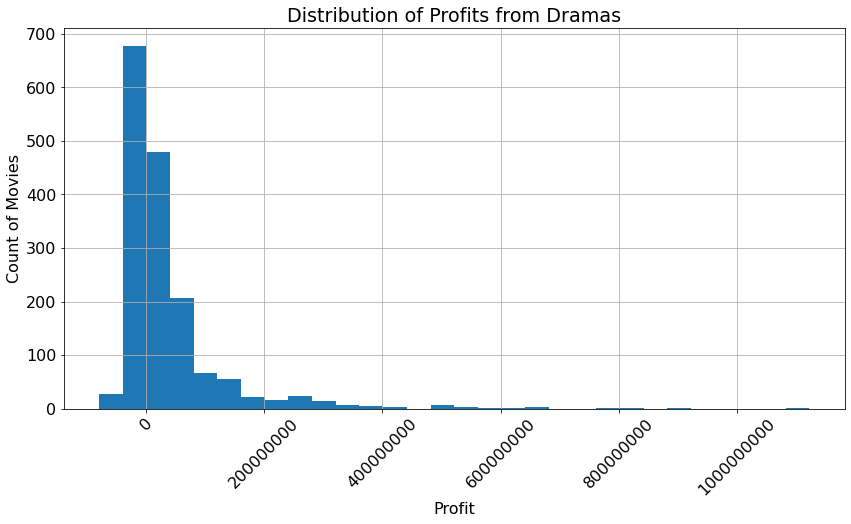

In [94]:
plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams.update({'font.size': 16})
drama_plot = drama_df['profit'].hist(bins = 30, xrot = 45)
drama_plot.set(xlabel= "Profit", ylabel="Count of Movies", title="Distribution of Profits from Dramas")
drama_plot.ticklabel_format(style = 'plain');

In [79]:
action_df = genre_filter(budget_genre_df, "Action")
action_df = action_df[action_df["production_budget"] > 1000000]
action_df.head(10)

,id,release_date,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres,profit
12 Rounds,37,"Mar 27, 2009",20000000,12234694,17306648,tt3517850,12 Rounds,2017,NaN,"Action,Drama,Romance",-2693352
12 Strong,64,"Jan 19, 2018",35000000,45819713,71118378,tt1413492,12 Strong,2018,130.0,"Action,Drama,History",36118378
2 Guns,39,"Aug 2, 2013",61000000,75612460,132493015,tt1272878,2 Guns,2013,109.0,"Action,Comedy,Crime",71493015
21 Jump Street,44,"Mar 16, 2012",42000000,138447667,202812429,tt1232829,21 Jump Street,2012,109.0,"Action,Comedy,Crime",160812429
22 Jump Street,85,"Jun 13, 2014",50000000,191719337,331333876,tt2294449,22 Jump Street,2014,112.0,"Action,Comedy,Crime",281333876
3 Days to Kill,64,"Feb 21, 2014",28000000,30697999,38959900,tt2172934,3 Days to Kill,2014,117.0,"Action,Drama,Thriller",10959900
30 Minutes or Less,60,"Aug 12, 2011",28000000,37053924,40966716,tt1622547,30 Minutes or Less,2011,83.0,"Action,Comedy,Crime",12966716
300: Rise of an Empire,26,"Mar 7, 2014",110000000,106580051,330780051,tt1253863,300: Rise of an Empire,2014,102.0,"Action,Fantasy,War",220780051
47 Ronin,12,"Dec 25, 2013",175000000,38362475,151716815,tt1335975,47 Ronin,2013,128.0,"Action,Adventure,Drama",-23283185
5 Days of War,47,"Aug 19, 2011",12000000,17479,87793,tt1486193,5 Days of War,2011,113.0,"Action,Drama,War",-11912207


In [80]:
action_df['profit'].mean()

119391796.94807121

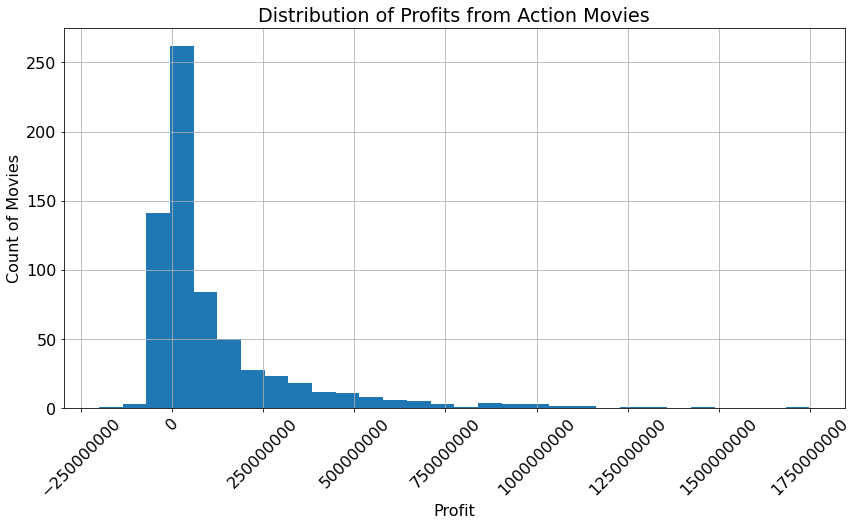

In [95]:
action_plot = action_df['profit'].hist(bins = 30, xrot = 45)
action_plot.set(xlabel= "Profit", ylabel="Count of Movies", title="Distribution of Profits from Action Movies")
action_plot.ticklabel_format(style = 'plain');

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [6]:
# Here you run your code to clean the data

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [ ]:
# Here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***